# Random Forests Model

The one uses the basic model and splits the test and training set by:
* Year
* Entire constituencies

In [79]:
from pyquery import PyQuery as pq
import urllib2
import requests
import pandas as pd
import re
import time
import numpy as np
import json
import matplotlib.pyplot as plt
from time import sleep
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 400)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

from sklearn.metrics import roc_curve, auc
from scipy import interp

### Load dataset and make variables categorical

In [80]:
ls_2014 = "http://myneta.info/ls2014/index.php?action=show_winners&sort=default"
ls_2009 = "http://myneta.info/ls2009/index.php?action=show_winners&sort=default"
ls_2004 = "http://myneta.info/loksabha2004/index.php?action=show_winners&sort=default"
base_2014 = "http://myneta.info/ls2014/"
base_2009 = "http://myneta.info/ls2009/"
base_2004 = "http://myneta.info/loksabha2004/"

url_list={'2004':ls_2004,'2009':ls_2009,'2014':ls_2014}
base_urls = {'2004':base_2004,'2009':base_2009,'2014':base_2014}

In [81]:
candidates = pd.read_csv('../candidates.csv')   
test_size = 0.2
train_size = 0.8

candidates.Party = candidates['Party'].astype('category')
candidates.Constituency = candidates['Constituency'].astype('category')
candidates.State = candidates['State'].astype('category')
candidates.Education = candidates['Education'].astype('category')
candidates.Assets_Rs = candidates.Assets_Rs.convert_objects(convert_numeric=True)
## Some null values in Assets that needed to be cleaned up
candidates.loc[candidates.Assets_Rs.isnull(),'Assets_Rs'] = 0

candidates.Constituency = candidates.Constituency.cat.rename_categories(range(0,len(candidates.Constituency.unique())))
candidates.Party = candidates.Party.cat.rename_categories(range(0,len(candidates.Party.unique())))
candidates.State = candidates.State.cat.rename_categories(range(0,len(candidates.State.unique())))
candidates.Education = candidates.Education.cat.rename_categories(range(0,len(candidates.Education.unique())))




/Users/sidravinutala1/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Merging 'Type of Crime'

In [82]:
crim_data = pd.read_csv('../criminal_record.csv')

gby_type = crim_data.groupby(['url','type']).count()
gby_type = gby_type.reset_index()
gby_type_piv = gby_type.pivot(index='url',columns='type',values='IPC_sections')
candidates['full_link'] = candidates.Year.apply(lambda x: base_urls[str(x)]) + candidates.Link

candidates = candidates.merge(gby_type_piv, how='left', left_on='full_link', right_index=True)
candidates.loc[candidates.Cogniz.isnull(),'Cogniz'] = 0
candidates.loc[candidates.Framed.isnull(),'Framed'] = 0
candidates.loc[candidates.Convict.isnull(),'Convict'] = 0

Incorporating incumbency

In [83]:
def find_year(yr_string):
    found = re.findall(r'\d+',yr_string)
    if len(found):
        return found[0]
    else :
        return "0"

In [88]:
multi_elect = pd.read_csv('../multiple_elections.csv')
multi_elect['year'] = multi_elect.elec_link.apply(lambda x: find_year(x.split('/')[3]))
#print multi_elect.head(3)


prev_list = []
for link, df in multi_elect.groupby('common_link'):
        df.ite = df.sort_values('year')
        prev_elec = {'common_link':link}
        for x,y in df[['elec_link','year']].iteritems():                    
            prev_elec[x] = list(y)
        win = []
        for y in prev_elec['elec_link']:
            winner = candidates.loc[candidates.full_link == y, 'Winner']
            if len(winner > 0):
                win.append(int(winner.iloc[0]))
            else :
                win.append(0)
        prev_elec['win'] = win
        prev_list.append(prev_elec)

Following take a while to run. You may want to load the csv file instead.

In [89]:
# Adding recent race information

def greater_years(year):
    year_list = []
    year_int = int(year)
    for y in d['year']:
        if int(y) < year_int:
            year_list.append(y)
    return len(year_list)

def recent_years(year):
    year_list = []
    y_small = 0
    year_int = int(year)
    for y in d['year']:
        y_int = int(y)
        if (y_int < year_int) and (y_int > y_small) :
            y_small = y_int
    return (year_int - y_small)

def total_wins(year):
    win_list = []
    year_int = int(year)
    for i,y in enumerate(d['year']):
        if int(y) < year_int:
            win_list.append(d['win'][i])
    return np.sum(win_list)
    
for d in prev_list:
    for i,link in enumerate(d['elec_link']):
        candidates.loc[candidates.full_link == link, 'Other_years'] = str(d['year'])
        candidates.loc[candidates.full_link == link, 'Total_Wins'] = candidates.Year.apply(total_wins)
        candidates.loc[candidates.full_link == link, 'History'] = candidates.Year.apply(greater_years)
        candidates.loc[candidates.full_link == link, 'Years_since'] = candidates.Year.apply(recent_years)
        candidates.loc[candidates.full_link == link, 'Incumbent'] = candidates.Years_since.apply(lambda x: (x<=5) and (x>0))
        candidates.loc[candidates.full_link == link, 'Other_elec'] = len(d['year'])
        candidates.loc[candidates.full_link == link, 'Common_link'] = d['common_link']
        if float(i%100.0) == 0.0:
            print ".",
            
candidates.head(3)

,Unnamed: 0,Age,Assets_Rs,Constituency,Criminal_Cases,Education,Liabilities_Rs,Link,Name,Party,State,Winner,Year,full_link,Cogniz,Convict,Framed,Other_years,Total_Wins,History,Years_since,Incumbent,Other_elec,Common_link
0,0,64,5658980,28,1,5,175115,candidate.php?candidate_id=585,Bishnu Pada Ray,132,0,1,2014,http://myneta.info/ls2014/candidate.php?candid...,0,0,1,"['2014', '2009', '2004']",1,2,5,True,3,http://myneta.info/compare_profile.php?group_i...
1,1,41,859410,28,0,1,350000,candidate.php?candidate_id=901,A Pandian,27,0,0,2014,http://myneta.info/ls2014/candidate.php?candid...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,48,5471073,28,1,5,6000,candidate.php?candidate_id=584,Anita Mondal,32,0,0,2014,http://myneta.info/ls2014/candidate.php?candid...,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Following code saves/loads the CSV, you can just start from here

In [90]:
candidates.to_csv('../candidates_incumbency_crim.csv')

In [ ]:
candidates = pd.read_csv('../candidates_incumbency_crim.csv')

Merging 'Code of Crime'

In [92]:
def concat_IPC(IPC):
    list = []
    for x in IPC:
        list = list + x.strip('[').strip(']').split(', ')
    return list

IPCs = crim_data[['url','IPC_sections']].groupby('url').agg(concat_IPC)
IPCs.head(3)

,IPC_sections
url,
http://myneta.info/loksabha2004/candidate.php?candidate_id=1005,"[307, 326, 324, 147, 148, 149, 307, 143, 147, ..."
http://myneta.info/loksabha2004/candidate.php?candidate_id=1012,"[419, 420, 120B]"
http://myneta.info/loksabha2004/candidate.php?candidate_id=1015,"[143, 144, 145, 147, 148]"


In [93]:
# Collect all the lists
y=[]
for x in crim_data.IPC_sections:
    x = x.strip('[').strip(']').split(', ')
    type(y)
    y = y + x

# Get a set of unique codes
z=[]
for code in y:
    if len(code) > 0:
        z.append(code)
unique_codes = list(set(z))

for col in unique_codes:
    IPCs[col] = IPCs.IPC_sections.apply(lambda x: int(col in x))

candidates = candidates.merge(IPCs,how='left',left_on='full_link',right_index=True)

In [94]:
for cols in candidates.columns:
    candidates.loc[candidates[cols].isnull(),cols] = 0

Save/Load the final dataset

In [95]:
candidates.to_csv('../candidates_final.csv')

In [ ]:
candidates = pd.read_csv('../candidates_final.csv')

## 1. With a very simple dataset

###Create test and train set

In [96]:
def gen_test_train(df, RATIO, TYPE):

    if TYPE == 'YEAR':
        train_df = df[df.Year.isin([2009,2004])]
        test_df = df[df.Year == 2014]
        print "Using 'YEAR' split"
    
    elif TYPE == 'CONST':
        print "Using 'CONSTITUENCY' split"
        df['year_const'] = df.Year.apply(str) + df.Constituency.apply(str)
        all_year_const = df.year_const.drop_duplicates()
        test_index=np.random.choice(all_year_const, size=RATIO*all_year_const.count(), replace=False)

        train_df = df[~df.year_const.isin(test_index)]
        test_df = df[df.year_const.isin(test_index)]
    
    else:
        test_index=np.random.choice(range(df.count()[0]), size=RATIO*df.count()[0], replace=False)
        test_mask = df.index.isin(list(test_index))
        test_df = df[test_mask]
        train_df = df[~test_mask]
    
    print "Train set: %s, Test set: %s" % (train_df.count()[0], test_df.count()[0])
    
    cols = ['Age', 'Constituency', 'Criminal_Cases', 'Assets_Rs','Year',
                                  'Education', 'Liabilities_Rs', 'Party', 'State','Cogniz','Convict','Framed',
                                  'Total_Wins','History','Years_since','Incumbent']
                       
                       
#     cols = list(train_df.columns)
#     cols.remove('Winner')
#     cols.remove('Unnamed: 0')
#     cols.remove('IPC_sections')
#     cols.remove('full_link')    
#     cols.remove('Name')
#     cols.remove('Link')
    
    X_train = train_df[cols]
    X_test = test_df[cols]

    Y_train = train_df.Winner
    Y_test = test_df.Winner
    
    return X_train, Y_train, X_test, Y_test
   

###A poor effort at balancing - creating weights

In [97]:
def generate_weights(Y, X_train):
    
    weight = [0,0]
    number_of_wins = np.sum(Y)
    weight[1] = float(number_of_wins)/len(Y)
    weight[0] = 1.0-weight[1]
    
    sample_weights = [weight[x] for x in Y]
    
    return np.array(sample_weights)


###Define a few functions for a random forest classfier

In [98]:
def run_rforest(x_train, y_train, x_test, y_test, weight, est_type, n_est=100):
    
    rf = RandomForestClassifier(n_estimators=n_est)
    rf.fit(x_train, y_train, sample_weight=weight)

    prob = [x[1] for x in rf.predict_proba(x_test)]
    x_test_cp = x_test.copy()
    x_test_cp['y_hat'] = prob
    x_test_cp['y'] = y_test
    all_dfs = []
    if (est_type == 'YEAR') or (est_type == 'CONST'):
        big_df = pd.DataFrame()
        for const, df in x_test_cp.groupby('Constituency'):
            df = df.sort_values(['y_hat'],ascending=False)
            if len(df) > 0 :
                df['out'] = [0] * len(df)
                df.out.iloc[0] = 1
                if len(df) > 1:
                    df.out.iloc[1] = 2
                df = df.reset_index()
                all_dfs.append(df)
        big_df = pd.concat(all_dfs)
        return rf, big_df.out, big_df.y
    else:
        y_hat = []
        for val in prob:
            if val > est_type:
                y_hat.append(1)
            else:
                y_hat.append(0)
        return rf, y_hat, y_test
        


In [99]:
def confusion_matrix(y_hat, y, val=[1]):
    y_hat = list(y_hat)
    y = list(y)
    conf = [[0,0],[0,0]]
    score = 0.0
    for i,x in enumerate(y_hat):
        if x in val :
            if y[i] == 1:
                conf[1][1] += 1
                score += 1
            if y[i] == 0:
                conf[0][1] += 1
        if x not in val:
            if y[i] == 1:
                conf[1][0] += 1
            if y[i] == 0:
                conf[0][0] += 1    
                score += 1
    return conf, score/len(y_hat)

In [100]:
def make_roc(clf, testset, y, save=False, ax=False):
    probas_ = clf.predict_proba(testset)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y, probas_[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,8))
    if not(ax):
        ax = plt.axes()
        
    ax.plot(fpr, tpr, lw=2, label='RF (area = %0.2f)' % (roc_auc))
    ax.plot([0,1],[0,1],ls='--')
    ax.legend(loc=0)

    if save :
        plt.savefig('roc_rf1.png', format='png')
    
    return ax

###Run the functions above splitting training and test sets by constituency

Using 'CONSTITUENCY' split
Train set: 15408, Test set: 3726
If you guessed all as losing: 0.916264090177
Current model: 0.940955448202
Confusion matrix [0,1],[0,1]: [[3307, 107], [113, 199]]


/Users/sidravinutala1/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


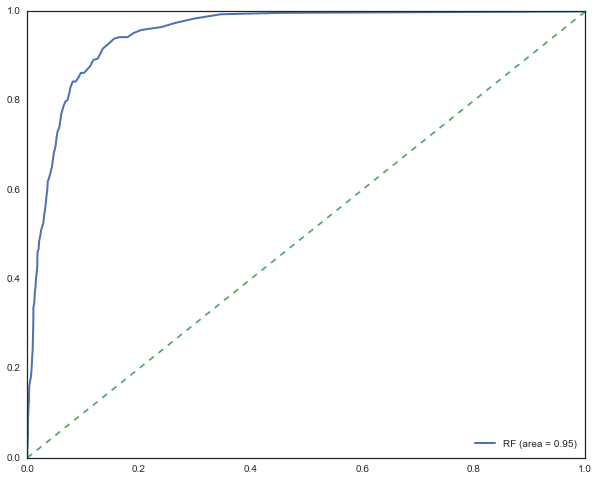

In [101]:
# get dataset
X_train, Y_train, X_test, Y_test = gen_test_train(candidates, 0.2, 'CONST')
weights = generate_weights(Y_train, X_train)
(rf, Y_hat, Y) = run_rforest(X_train, Y_train, X_test, Y_test, weights, 'CONST', n_est=100)
conf, score = confusion_matrix(Y_hat, Y)
all_zeroes = [0]*len(Y_hat)

print "If you guessed all as losing: %s" % (1.0 - float(np.sum(Y_test))/len(Y_test))
print "Current model: %s" % score
print "Confusion matrix [0,1],[0,1]: %s" % conf

ax = make_roc(rf, X_test, Y_test, save=False)

### Now run by splitting by year

Using 'YEAR' split
Train set: 10930, Test set: 8204
If you guessed all as losing: 0.933934666017
Current model: 0.917357386641
Confusion matrix [0,1],[0,1]: [[7324, 338], [340, 202]]


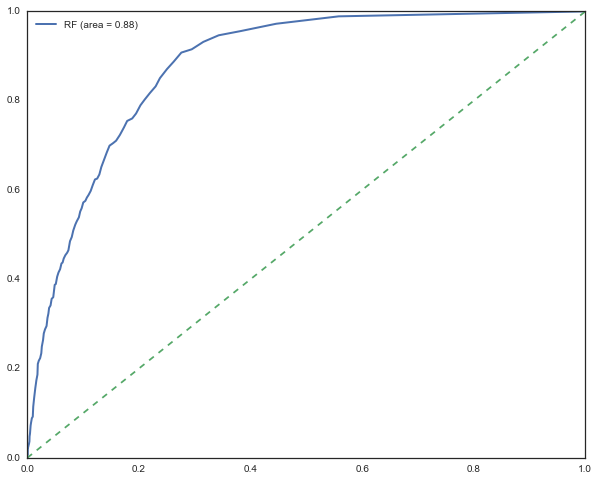

In [102]:
# get dataset
X_train, Y_train, X_test, Y_test = gen_test_train(candidates, 0.2, 'YEAR')
weights = generate_weights(Y_train, X_train)
(rf, Y_hat, Y) = run_rforest(X_train, Y_train, X_test, Y_test, weights, 'YEAR', n_est=100)
conf, score = confusion_matrix(Y_hat, Y)
all_zeroes = [0]*len(Y_hat)

print "If you guessed all as losing: %s" % (1.0 - float(np.sum(Y_test))/len(Y_test))
print "Current model: %s" % score
print "Confusion matrix [0,1],[0,1]: %s" % conf

make_roc(rf, X_test, Y_test, save=False)

### Finally, the 'classic' version ###

Train set: 15308, Test set: 3826
If you guessed all as losing: 0.920020909566
Current model: 0.934396236278
Confusion matrix [0,1],[0,1]: [[3386, 134], [117, 189]]


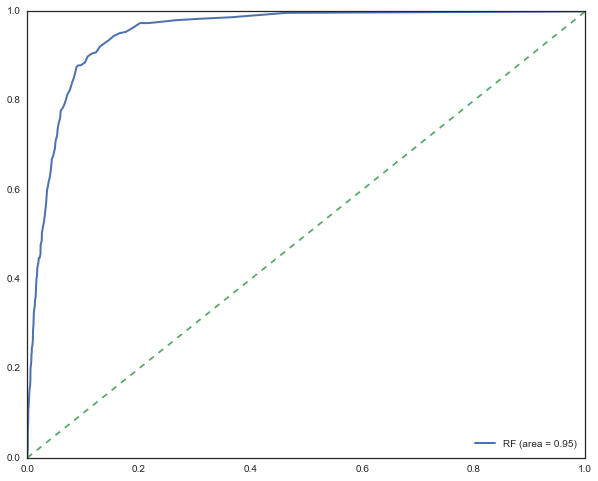

In [103]:
# get dataset
X_train, Y_train, X_test, Y_test = gen_test_train(candidates, 0.2, 0.40)
weights = generate_weights(Y_train, X_train)
(rf, Y_hat, Y) = run_rforest(X_train, Y_train, X_test, Y_test, weights, 0.40, n_est=100)
conf, score = confusion_matrix(Y_hat, Y, val=[1,2])
all_zeroes = [0]*len(Y_hat)

print "If you guessed all as losing: %s" % (1.0 - float(np.sum(Y_test))/len(Y_test))
print "Current model: %s" % score
print "Confusion matrix [0,1],[0,1]: %s" % conf

make_roc(rf, X_test, Y_test, save=False)